In [6]:
import yaml
import torch
import numpy as np
from pathlib import Path
from prodict import Prodict

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from sophie.trainers.trainer_sophie_adaptation import n_data, dn_data
from sophie.utils.utils import relative_to_abs_sgan
from sophie.models.sophie_adaptation import TrajectoryGenerator
from sophie.data_loader.argoverse.dataset_sgan_version import ArgoverseMotionForecastingDataset, seq_collate

## Load config 

In [2]:
BASE_DIR = "/home/robesafe/tesis/SoPhie"

with open(r'./configs/sophie_argoverse.yml') as config:
    config = yaml.safe_load(config)
    config = Prodict.from_dict(config)
    config.base_dir = BASE_DIR

# Fill some additional dimensions

past_observations = config.hyperparameters.obs_len
num_agents_per_obs = config.hyperparameters.num_agents_per_obs
config.sophie.generator.social_attention.linear_decoder.out_features = past_observations * num_agents_per_obs

## Load dataset

In [3]:
split_percentage = 0.02
batch_size = 1
# data = ArgoverseMotionForecastingDataset(dataset_name=config.dataset_name,
#                                                   root_folder=config.dataset.path,
#                                                   obs_len=config.hyperparameters.obs_len,
#                                                   pred_len=0,
#                                                   distance_threshold=config.hyperparameters.distance_threshold,
#                                                   split="test",
#                                                   num_agents_per_obs=config.hyperparameters.num_agents_per_obs,
#                                                   split_percentage=split_percentage)

data = ArgoverseMotionForecastingDataset(dataset_name=config.dataset_name,
                                                 root_folder=config.dataset.path,
                                                 obs_len=config.hyperparameters.obs_len,
                                                 pred_len=config.hyperparameters.pred_len,
                                                 distance_threshold=config.hyperparameters.distance_threshold,
                                                 split="val",
                                                 num_agents_per_obs=config.hyperparameters.num_agents_per_obs,
                                                 split_percentage=split_percentage,
                                                 shuffle=config.dataset.shuffle)


loader = DataLoader(data,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=0,
                    collate_fn=seq_collate)

Start Dataset
Dataset time:  5.324504852294922


## Load generator from checkpoint

In [4]:
model_path = "./save/argoverse/test/argoverse_motion_forecasting_dataset_0_with_model.pt"
checkpoint = torch.load(model_path)
generator = TrajectoryGenerator(config.sophie.generator)
generator.load_state_dict(checkpoint.config_cp['g_best_state'])
generator.cuda() # Use GPU
generator.eval()

TrajectoryGenerator(
  (visual_feature_extractor): VisualExtractor(
    (module): VGG(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, ke

## Run test

In [5]:
num_samples = 5
output_all = []
with torch.no_grad():
    for batch_index, batch in enumerate(loader):
        if batch_index > 100:
            break
        batch = [tensor.cuda() for tensor in batch]
        
        (obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_obj,
                    loss_mask, seq_start_end, frames, object_cls, obj_id, ego_origin, num_seq_list, n) = batch
        predicted_traj = []
        agent_idx = int(torch.where(object_cls==1)[0].cpu().item())
        traj_real = torch.cat([obs_traj, pred_traj_gt], dim=0)
        predicted_traj.append(traj_real[:, agent_idx,:])
        for _ in range(num_samples):

            # Get predictions
            pred_traj_fake_rel = generator(
                n_data(obs_traj),
                n_data(obs_traj_rel), 
                frames,
                agent_idx
            )

            # Get predictions in absolute coordinates
            pred_traj_fake = relative_to_abs_sgan(pred_traj_fake_rel, obs_traj[-1])
            traj_fake = torch.cat([obs_traj, pred_traj_fake], dim=0)
            predicted_traj.append(traj_fake[:,agent_idx,:])
        predicted_traj = torch.stack(predicted_traj, axis=0)
        predicted_traj = predicted_traj.cpu().numpy()
        output_all.append(predicted_traj)

ValueError: too many values to unpack (expected 12)

## Show trajectories

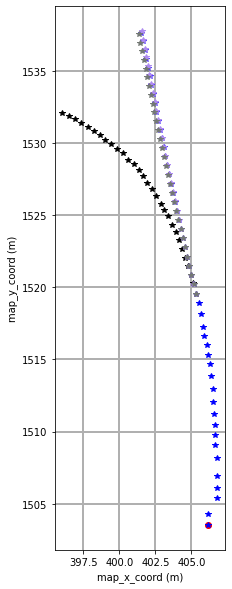

In [29]:
import matplotlib
ax = plt.gca()

predicted_traj = output_all[4]
with plt.rc_context({'xtick.color': 'white', 'ytick.color': 'white'}):
    plt.grid(linestyle='-', linewidth=2)
    plt.plot(predicted_traj[0,0,0],predicted_traj[0,0,1],'-o',c='r') #starting point here
    plt.plot(predicted_traj[0,:21,0],predicted_traj[0,:21,1],'*',c='b')

    for i in range(len(predicted_traj)):
        if i == 0:
            c = 'black'
        else:
            c= np.random.rand(3,)
        plt.plot(predicted_traj[i,20:,0],predicted_traj[i,20:,1],'*',c=c)#np.random.rand(3,)
    plt.xlabel('map_x_coord (m)')
    plt.ylabel('map_y_coord (m)')

    ax.set_aspect('equal')
    ax.figure.set_size_inches(10,10)
    plt.show()

In [22]:
predicted_traj.shape
predicted_traj[:, 0,:]

array([[1536.6025 ,  241.84793],
       [1536.5859 ,  241.86697],
       [1536.5889 ,  241.87119],
       [1536.5875 ,  241.87154],
       [1536.6002 ,  241.83514],
       [1536.5891 ,  241.86632]], dtype=float32)